In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import math

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import seaborn as sns
import warnings

from operator import add
from functools import reduce

warnings.filterwarnings('ignore')
np.random.seed(2017)

%run ../src/stochastic_helpers.py

### Evaluation Function

In [3]:
def evaluate_bag(bag, n_samples=10000):
    bag_weight_sampler = create_bag_weight_sampler(bag)
    bag_weight_samples = bag_weight_sampler(n_samples)
    
    return np.mean(bag_weight_samples)

In [139]:
def evaluate_bag(bag, n_samples=10000):
    """
    Estimates the weight of a bag with a certain configuration
    It would any samples where total weight went beyond 50 to 0,
    so that those bags would be penalized eventually.
    
    Optimization: Instead of generate all samples, generate n_samples / 1000
    and see if the samples show low variance then stop otherwise continue for
    whole number of samples initially asked for.
    """
    
    batch_samples = int(n_samples / 1000)
    
    bag_weight_sampler = create_bag_weight_sampler(bag)
    bag_weight_samples = bag_weight_sampler(batch_samples)
    bag_weight_samples[bag_weight_samples > 50] = 0
    
    mean_weight_bag = np.mean(bag_weight_samples)
    std_weight_bag  = np.std(bag_weight_samples)
    
    if mean_weight_bag > 28. and std_weight_bag < 7.:
        # pretty sure about the estimated result
        return mean_weight_bag
    elif mean_weight_bag > 20. and std_weight_bag > 7.:
        # not very sure about the result may need more iterations
        remaining_samples = n_samples - batch_samples
        bag_weight_samples = bag_weight_sampler(remaining_samples)
        bag_weight_samples[bag_weight_samples > 50] = 0
    
        mean_weight_bag = np.mean(bag_weight_samples)
        
        return mean_weight_bag
    else:
        # no chance
        return mean_weight_bag

** Maximum Item Possible **

In [140]:
max_item_possible = [26, 3, 5, 25, 3, 10, 36, 11, 5]

### Genetic Algorithm ( Heuristic )

In [141]:
def individual(max_item_possible):
    'Create a member of the population.'
    length = len(max_item_possible)
    
    return np.array([np.random.randint(0, member + 1) for member in max_item_possible])

def population(count, max_item_possible):
    """
    Create a number of individuals ( i.e population)
    """
    
    return np.array([individual(max_item_possible) for i in range(count)])

def fitness(individual, weight_constraint):
    """
    Determines the fitness of the individual, lower is better.
    """
    
    estimated_weight = evaluate_bag(individual)
    return weight_constraint - estimated_weight

def grade(pop, weight_constraint):
    'Find average fitness for a population.'
    summed = reduce(add, (fitness(x, weight_constraint) for x in pop), 0)
    return summed / len(pop)

In [142]:
def evolve(pop, weight_constraint, max_item_possible, retain=0.2, random_select=0.05, mutate=0.01):
    graded = [ (fitness(x, weight_constraint), x) for x in pop]
    graded = [ x[1] for x in sorted(graded, key=lambda x: x[0])]
        
    retain_length = int(len(graded)*retain)
    parents = graded[:retain_length]

    # randomly add other individuals to promote genetic diversity
    for individual in graded[retain_length:]:
        if random_select > np.random.random():
            parents.append(individual)

    # mutate some individuals
    for individual in parents:
        if mutate > np.random.random():
            pos_to_mutate = np.random.randint(0, len(individual)-1)
            # this mutation is not ideal, because it
            # restricts the range of possible values,
            # but the function is unaware of the min/max
            # values used to create the individuals,
            individual[pos_to_mutate] = np.random.randint(0, max_item_possible[pos_to_mutate] + 1)

    # crossover parents to create children
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []
    
    parents  = list(parents) # convert numpy array to list
    
    while len(children) < desired_length:
        male = np.random.randint(0, parents_length-1)
        female = np.random.randint(0, parents_length-1)
        
        if male != female:
            male_individual = list(parents[male])
            female_individual = list(parents[female])
        
            half = int(len(male_individual) / 2)
            child = male_individual[:half] + female_individual[half:]
            children.append(child)

#     parents.extend(children)
    return np.array(parents) # convert it back to numpy array

** Generate solutions **

In [227]:
weight_constraint = 50
runs = 25000

modified_max_item_possible    = list(map(np.floor, np.array(max_item_possible) / 2.7))
pop = population(runs, modified_max_item_possible)

** Computational Effort **

In [287]:
def get_cumulative_prob(pop, weight_constraint, threshold):
    results = np.array([grade(pop[i:i+1], weight_constraint) for i in range(len(pop))])
    return np.sum(results > threshold) / len(results)

def get_computation_effort(runs, cum_prob, z=0.99):
    return runs * (np.log(1 - z) / np.log(1 - cum_prob))

In [144]:
cum_prob = get_cumulative_prob(pop, weight_constraint, 38.)
print('cumulative probability ', cum_prob)
num_evaluations_needed = get_computation_effort(runs, cum_prob)
print('Num evaluations needed  ', num_evaluations_needed)

NameError: name 'get_cumulative_prob' is not defined

** This would mean that it would take x evaluations to say that 99% of the time that estimated weight of the bag would be 38.  where x being the number of evaluations required. **

In [228]:
evolved_pop = evolve(pop.copy(), weight_constraint, \
                     modified_max_item_possible, retain=0.1,\
                     random_select=0.01, mutate=0.5)

** Let's find out the performace of the bag **

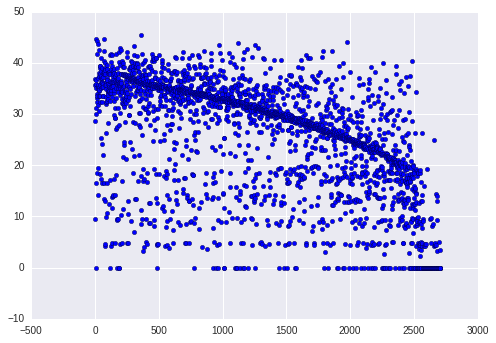

In [229]:
perf = np.array(list(map(evaluate_bag, evolved_pop)))
plt.scatter(np.arange(0, len(evolved_pop)), perf);

In [202]:
print(np.sum(perf), np.std(perf))

8501.32676836 12.000900367


### Bin Packing

In [148]:
num_gifts_available = {
    "horse": 1000,
    "ball": 1100,
    "bike": 500,
    "train": 1000,
    "book": 1200,
    "doll": 1000,
    "blocks": 1000,
    "gloves": 200,
    "coal": 166
}

available_count = np.array([num_gifts_available[gift_type] for gift_type in gift_types])

In [210]:
def repeat_solutions(df, available_count):
    solution_space = []
    for i in range(len(df)):
        mask = (df.iloc[i] > 0).values
        repeat_count = np.min((available_count[mask] / df.iloc[i][mask]).map(np.floor))
        solution_space.append(np.repeat([df.iloc[i].values], repeat_count, axis=0))
    
    return np.vstack(solution_space)

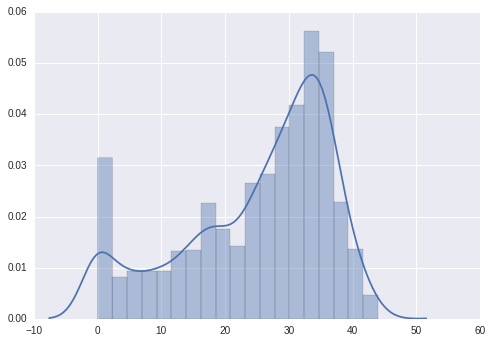

In [230]:
# solutions = generate_solutions(max_item_count)
df = pd.DataFrame(evolved_pop)
df = df.drop_duplicates()
evolved_estimated_df = df.apply(evaluate_bag, axis=1)
sns.distplot(evolved_estimated_df);

In [231]:
mask = evolved_estimated_df > 20.
df   = df.loc[mask]

In [232]:
# generate the total search space based on evaluation function
# solution_space = repeat_solutions(df, available_count)
solution_space = df.values

In [233]:
len(solution_space)

1869

In [154]:
def pack_linprog(bags, distributions, min_variance, max_bags=1000):
    # objective: c.T * x -> min
    c = - distributions[:,0] # optimize sum of expected bag utilities
    
    # constraint: A_ub * x <= b_ub
    A_ub = bags.T # don't use more gifts than available
    b_ub = np.array([num_gifts_available[gift] for gift in gift_types])
    
    A_ub = np.vstack([A_ub, np.ones(A_ub.shape[1])]) # pack at most max_bags gifts
    b_ub = np.hstack([b_ub, [max_bags]])
    
    if min_variance is not None:
        A_ub = np.vstack([A_ub, -distributions[:,1]]) # require minimum variance
        b_ub = np.hstack([b_ub, [-min_variance]])
    
    result = sp.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub)
    if result["success"] == False:
        return [], True
    else:
        return result["x"].astype('int64'), False


def pack_bags(bags, distributions, min_variance=None):
    max_bags = 1000
    bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance)
    while np.sum(bag_quantities) < 1000:
        max_bags += 1
        bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance, max_bags=max_bags)
        if max_bags > 1015:
            print("WARNING: not getting 1000 bags")
            break
        if infeasible:
            continue
    
    if infeasible:
        print("infeasible")
        return [], [], []
    
    chosen_bag_idx = np.where(bag_quantities)[0]
    chosen_bags = bags[chosen_bag_idx]
    chosen_distributions = distributions[chosen_bag_idx]
    chosen_quantities = bag_quantities[chosen_bag_idx]
    
    while np.sum(chosen_quantities) > 1000:
        idx = np.random.randint(len(chosen_quantities))
        chosen_quantities[idx] = max (chosen_quantities[idx]-1, 0)
    
    score_distribution = np.dot(chosen_quantities, chosen_distributions)
    print("{} bags - score distribution: mean = {:.2f} | var = {:.2f}"
          .format(np.sum(chosen_quantities), score_distribution[0], score_distribution[1]))
    
    return chosen_bags, chosen_distributions, chosen_quantities

In [234]:
bag_utility_distributions = get_bag_utility_distributions(solution_space)
packed_bags, packed_distributions, packed_quantities \
    = pack_bags(solution_space, bag_utility_distributions, min_variance=None)

0.0000

1000 bags - score distribution: mean = 35044.63 | var = 105959.75


In [356]:
def create_submissions(bags, quantities, num_submissions=60):
    def create_stock(n):
        stock = { gift: list(map(lambda id: "{}_{}".format(gift, id) ,np.arange(num_gifts_available[gift]))) for gift in gift_types }
        return shuffle(stock, n)
    
    def shuffle(stock, seed):
        np.random.seed(seed)
        for gift in stock.keys():
            np.random.shuffle(stock[gift])
        return stock
    
    def generate_submission(n):
        from datetime import datetime
        curr_time_str = datetime.today().strftime("%B %d, %Y %H:%M:%S")
        
        stock = create_stock(n)
        with open("../submissions/submission_without_coal_{}_{}.csv".format(curr_time_str, n), 'w+') as submission_file:
            submission_file.write('Gifts\n')
            for i in range(len(bags)):
                for quantity in range(quantities[i]):
                    current_gifts = bags[i]
                    for gift_idx, gift_quantity in enumerate(current_gifts[:len(gift_types)]):
                        gift_name = gift_types[gift_idx]
                        for j in range(int(gift_quantity)):
                            submission_file.write("{} ".format(stock[gift_name].pop()))
                    submission_file.write("\n")
    
    for n in range(num_submissions):
        generate_submission(n)

In [367]:
create_submissions(packed_bags, packed_quantities)